In [50]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.utils import shuffle
from scipy.stats import ranksums
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval
import pandas as pd
from hyperopt.pyll import scope
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('C:/Users/Multiplexon/Desktop/data/2/total_selected_augmented.csv', sep=',')
df.head()

,Transaction Hash_len,Original_len,signature_len,From_len,To_len,sender_len,paymaster_len,Txn Fee,Gas Used,logIndex,actualGasCost,actualGasUsed,nonce,success,Blockno,DateTime_ts
0,32,964,4,20,20,20,20,0.022033,398741,245,2.190000e+16,397164,0.0,1,17066994,1681740540
1,32,868,4,20,20,20,20,0.004362,87702,231,4.280000e+15,86113,1.0,1,17067000,1681740600
2,32,868,4,20,20,20,20,0.003971,87714,273,3.900000e+15,86125,2.0,1,17067009,1681740720
3,32,1188,4,20,20,20,20,0.008673,161702,429,8.650000e+15,161161,3.0,1,17078992,1681887000
4,32,1188,4,20,20,20,20,0.006445,127502,393,6.420000e+15,126973,4.0,1,17079029,1681887420


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

features = ['Transaction Hash_len','Original_len','signature_len',
            'From_len','To_len','sender_len','paymaster_len',
            'Txn Fee','logIndex','actualGasCost',
            'actualGasUsed','nonce','success','Blockno','DateTime_ts']

# Tách X và y
X = df.loc[:, features]
y = df['Gas Used']

# 1) Split trước
X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=10, train_size=0.8, shuffle=True
)

print("Before scaling:")
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} "
      f"\nX_val: {X_val.shape}, \ny_val: {y_val.shape}")

# 2) Scale X bằng MinMaxScaler
scaler_X = MinMaxScaler()
X_train_scaled = pd.DataFrame(
    scaler_X.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler_X.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

# 3) Scale y bằng MinMaxScaler
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_val_scaled   = scaler_y.transform(y_val.values.reshape(-1,1)).ravel()

print("\nAfter scaling:")
print(f"X_train_scaled: {X_train_scaled.shape} \ny_train_scaled: {y_train_scaled.shape} "
      f"\nX_val_scaled: {X_val_scaled.shape}, \ny_val_scaled: {y_val_scaled.shape}")

# 4) Kiểm tra min/max sau khi scale
print("\nCheck scaling X_train (min/max):")
print(X_train_scaled.min().round(3))
print(X_train_scaled.max().round(3))

print("\nCheck scaling y_train (min/max):")
print(y_train_scaled.min().round(3), y_train_scaled.max().round(3))


Before scaling:
X_train: (87492, 15) 
y_train: (87492,) 
X_val: (21873, 15), 
y_val: (21873,)

After scaling:
X_train_scaled: (87492, 15) 
y_train_scaled: (87492,) 
X_val_scaled: (21873, 15), 
y_val_scaled: (21873,)

Check scaling X_train (min/max):
Transaction Hash_len    0.0
Original_len            0.0
signature_len           0.0
From_len                0.0
To_len                  0.0
sender_len              0.0
paymaster_len           0.0
Txn Fee                 0.0
logIndex                0.0
actualGasCost           0.0
actualGasUsed           0.0
nonce                   0.0
success                 0.0
Blockno                 0.0
DateTime_ts             0.0
dtype: float64
Transaction Hash_len    0.0
Original_len            1.0
signature_len           0.0
From_len                0.0
To_len                  0.0
sender_len              0.0
paymaster_len           0.0
Txn Fee                 1.0
logIndex                1.0
actualGasCost           1.0
actualGasUsed           1.0
nonce  

In [ ]:

# --- hyperparam space ---
catboost_hyperparams = {
    "learning_rate":    hp.uniform("learning_rate", 0.01, 0.2),
    "depth":            scope.int(hp.choice("depth", [2, 5, 10])),
    "iterations":       scope.int(hp.quniform("iterations", 2000, 12000, 500)),
    "l2_leaf_reg":      hp.uniform("l2_leaf_reg", 1.0, 10.0),
    "min_data_in_leaf": scope.int(hp.quniform("min_data_in_leaf", 50, 200, 1)),
    "random_strength":  hp.uniform("random_strength", 0.3, 1.5),
    "loss_function":    "RMSE",
    "eval_metric":      "RMSE",
    "verbose":          0,
    "random_seed":      10,     
    'task_type' : 'GPU',
    'devices' : '0'
}

# fit params cho .fit()
fit_params = {
    "early_stopping_rounds": 10,
    "verbose": False,
    "use_best_model": True,             # rất quan trọng để dùng best_iteration
}

space = {"reg_params": catboost_hyperparams, "fit_params": fit_params}

# --- optimiser ---
class HPOptimiser(object):
    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train; self.X_val = X_val
        self.y_train = y_train; self.y_val = y_val

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo,
                          max_evals=max_evals, trials=trials)
        except Exception as e:
            return {"status": STATUS_FAIL, "exception": str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para["reg_params"])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        # Dùng dữ liệu ĐÃ SCALE
        reg.fit(
            self.X_train, self.y_train,
            eval_set=(self.X_val, self.y_val),
            **params["fit_params"]
        )
        pred = reg.predict(self.X_val)
        rmse = float(np.sqrt(mean_squared_error(self.y_val, pred)))
        return {"loss": rmse, "status": STATUS_OK}

# --- chạy hyperopt với dữ liệu ĐÃ SCALE ---
MAX_EVALS = 2
trials = Trials()

# LƯU Ý: truyền X_train_scaled / X_val_scaled vào đây
optim  = HPOptimiser(X_train_scaled, X_val_scaled, y_train_scaled, y_val_scaled)

best_raw, trials = optim.process(
    fn_name="catboost_reg",
    space=space,
    trials=trials,
    algo=tpe.suggest,
    max_evals=MAX_EVALS
)

# --- decode best & in kết quả ---
best = space_eval(space, best_raw)
print("=== BEST (validation) ===")
print("Best RMSE:", trials.best_trial["result"]["loss"])
print("Best reg_params:", best["reg_params"])
print("Best fit_params:", best["fit_params"])

# --- train final với bộ tham số tốt nhất (trên dữ liệu ĐÃ SCALE) ---
final = CatBoostRegressor(**best["reg_params"])
final.fit(
    X_train_scaled, y_train_scaled,
    eval_set=(X_val_scaled, y_val_scaled),
    **best["fit_params"]
)
val_rmse = float(np.sqrt(mean_squared_error(y_val_scaled, final.predict(X_val_scaled))))
print("Final RMSE (val):", val_rmse)
print("Best iteration:", final.get_best_iteration())


  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 2/2 [00:40<00:00, 20.13s/trial, best loss: 0.00434711495215783]
=== BEST (validation) ===
Best RMSE: 0.00434711495215783
Best reg_params: {'depth': 10, 'eval_metric': 'RMSE', 'iterations': 7500, 'l2_leaf_reg': 1.808248298452685, 'learning_rate': 0.18469519799847653, 'loss_function': 'RMSE', 'min_data_in_leaf': 143, 'random_seed': 10, 'random_strength': 1.1614951096233768, 'verbose': 0}
Best fit_params: {'early_stopping_rounds': 10, 'use_best_model': True, 'verbose': False}
Final RMSE (val): 0.00434711495215783
Best iteration: 207


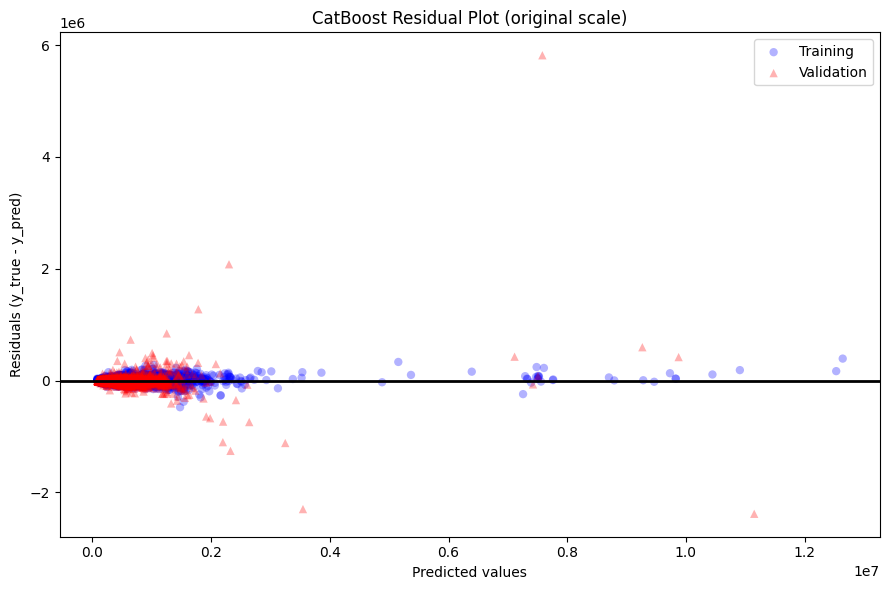

In [ ]:
train_preds_s = final.predict(X_train_scaled)
val_preds_s   = final.predict(X_val_scaled)

# 2) Inverse về thang đo gốc
train_preds = scaler_y.inverse_transform(train_preds_s.reshape(-1,1)).ravel()
val_preds   = scaler_y.inverse_transform(val_preds_s.reshape(-1,1)).ravel()
y_train_org = scaler_y.inverse_transform(y_train_scaled.reshape(-1,1)).ravel()
y_val_org   = scaler_y.inverse_transform(y_val_scaled.reshape(-1,1)).ravel()


def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                title="Residual Plot", figsize=(9,6)):
    plt.figure(figsize=figsize)
    # residual = y_true - y_pred
    plt.scatter(train_preds, train_labels - train_preds,
                c='blue', alpha=0.3, marker='o', edgecolors='none', label='Training')
    if test_labels is not None and test_preds is not None:
        plt.scatter(test_preds, test_labels - test_preds,
                    c='red', alpha=0.3, marker='^', edgecolors='none', label='Validation')
    plt.axhline(y=0, color='black', lw=2)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals (y_true - y_pred)')
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# 4) Gọi vẽ (thang đo gốc, KHÔNG trộn scaled nữa)
residual_plot(
    y_train_org, train_preds,
    y_val_org,   val_preds,
    title="CatBoost Residual Plot (original scale)"
)

C:\Users\Multiplexon\AppData\Local\Temp\ipykernel_30916\2649838709.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importances", y="Feature Id", data=top_feats, palette="viridis")


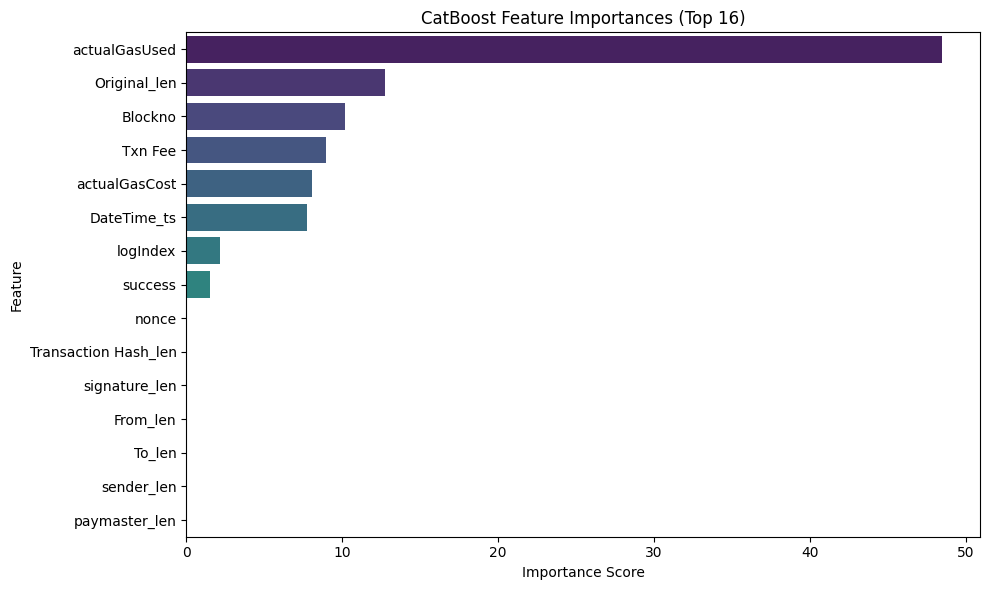

In [ ]:
feat_importances = final.get_feature_importance(prettified=True)
# the number of head 16
top_feats = feat_importances.sort_values(by="Importances", ascending=False).head(16)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=top_feats, palette="viridis")
plt.title("CatBoost Feature Importances (Top 16)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [56]:
#Final CatBoost Test Set Predictions using KFolds

N_FOLDS = 10
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# chứa metrics mỗi fold: [MAE, stdErr, RMSE]
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    train_split = X.iloc[train_idx].copy()
    train_labels = y.iloc[train_idx].astype(np.float64).copy()
    val_split   = X.iloc[val_idx].copy()
    val_labels  = y.iloc[val_idx].astype(np.float64).copy()

    val_pred = final.predict(val_split)

    #  metrics

    mae  = float(mean_absolute_error(val_labels, val_pred))
    stdE = float(np.std(residuals))
    rmse = float(np.sqrt(mean_squared_error(val_labels, val_pred)))

    fold_metrics.append([mae, stdE, rmse])
    print(f"Fold {fold}: MAE={mae:.4f} | stdErr={stdE:.4f} | RMSE={rmse:.4f} | best_iter={final.get_best_iteration()}")

fold_metrics = np.array(fold_metrics)
mae_mean, stdE_mean, rmse_mean = fold_metrics.mean(axis=0)
mae_std,  stdE_std,  rmse_std  = fold_metrics.std(axis=0)

print("\n=== K-FOLD SUMMARY ===")
print(f"MAE   : {mae_mean:.4f} ± {mae_std:.4f}")
print(f"stdErr: {stdE_mean:.4f} ± {stdE_std:.4f}")
print(f"RMSE  : {rmse_mean:.4f} ± {rmse_std:.4f}")


Fold 1: MAE=372876.7883 | stdErr=285529.7791 | RMSE=469642.7941 | best_iter=207
Fold 2: MAE=378587.5039 | stdErr=285529.7791 | RMSE=492182.0824 | best_iter=207
Fold 3: MAE=377147.7154 | stdErr=285529.7791 | RMSE=472070.0287 | best_iter=207
Fold 4: MAE=377297.1040 | stdErr=285529.7791 | RMSE=482735.2174 | best_iter=207
Fold 5: MAE=373098.1575 | stdErr=285529.7791 | RMSE=476804.0539 | best_iter=207
Fold 6: MAE=383058.7588 | stdErr=285529.7791 | RMSE=518558.3177 | best_iter=207
Fold 7: MAE=379400.7510 | stdErr=285529.7791 | RMSE=490637.7077 | best_iter=207
Fold 8: MAE=378933.7080 | stdErr=285529.7791 | RMSE=464676.9837 | best_iter=207
Fold 9: MAE=382678.9806 | stdErr=285529.7791 | RMSE=504545.4693 | best_iter=207
Fold 10: MAE=374493.9721 | stdErr=285529.7791 | RMSE=473564.5935 | best_iter=207

=== K-FOLD SUMMARY ===
MAE   : 377757.3440 ± 3374.3473
stdErr: 285529.7791 ± 0.0000
RMSE  : 484541.7248 ± 16151.0872
